In [1]:
# imports
import pickle
import glob
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import pandas
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

%matplotlib inline

In [4]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam


def model(input_shape):
    kernel_size = 3

    model = Sequential()
    model.add(Convolution2D(3,1,1, input_shape=input_shape))
    model.add(Convolution2D(24,kernel_size,kernel_size))
    model.add(ELU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(ELU())
    model.add(Dense(128))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(8))
    model.add(ELU())
    model.add(Dense(1))
    return model
    
m = model((32,32,3))  

In [40]:
def plot_images(images, label, n_cols=5):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(n_rows*20, n_cols*2))   
    for i,image in enumerate(images):
        image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        plt.title("Output " + str(label[i]))
        plt.imshow(image)
    plt.show()
    
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()    

In [29]:

# Using opencv functions to make Geometric Transformations
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate(image, tx=0, ty=0):
    '''
    Translate/Shift an image by (tx, ty) 
    '''
    # Translation matrix
    M = np.float32([[1,0,tx],[0,1,ty]])    
    return cv2.warpAffine(image,M,image.shape[0:2])

def rotate(image, angle=0):
    '''
    Rotate image by angle in degrees
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(image,M,image.shape[0:2])

def scale(image, factor=1.0):
    '''
    Scale image by factor
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,factor)    
    return cv2.warpAffine(image,M,image.shape[0:2])

def brighten(image, factor=1.0):
    '''
    Change brightness of image by factor
    '''
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image[:,:,2] = image[:,:,2] * factor
    return cv2.cvtColor(image,cv2.COLOR_HSV2RGB)

def blur(image, kernel=5):
    '''
    
    '''
    return cv2.medianBlur(image,kernel)
    
def sharpen(image):
    '''
    
    '''
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)



In [30]:
def generate_random_images(X,y):
    """
    Generate augmented images randomly
    """
    unique, unique_idx, unique_counts = np.unique(y, return_index=True, return_counts=True)
    max_count = np.max(unique_counts)

    for image, label in zip(X,y):        
        n_to_generate = int(max_count/unique_counts[label])
        for i in range(0,n_to_generate,5):
            image_aug = (translate(image, np.random.uniform(-5,5),np.random.uniform(-5,5)))
            yield image_aug,label 
            image_aug = (rotate(image,np.random.uniform(-10,10)))
            yield image_aug,label 
            image_aug = (scale(image,np.random.uniform(0.8,1.2)))
            yield image_aug,label   

In [ ]:
### Preprocess the data here.
# Implement Min-Max scaling for color image data
def normalize_color(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    color_min = 0
    color_max = 255
    return a + ( ( (image_data - color_min)*(b - a) )/( color_max - color_min ) )

In [6]:
path = './data/'
correction = 0.2
df_cars = pandas.read_csv(path + 'driving_log.csv')


In [ ]:


images = []
steerings = []
labels = []
for idx, row in df_cars.iterrows():
    img_center = np.asarray(plt.imread(path + row['center']))
    img_center = process_image(img_center)

    img_left = plt.imread(path + row['left'].replace(' ', ''))
    img_right = plt.imread(path + row['right'].replace(' ', ''))
    #images.append(img_center)
    steering_center = np.float32(row['steering'])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    steerings.append(steering_center)
    labels.append(np.sign(steering_center))

    
    


<class 'numpy.ndarray'>


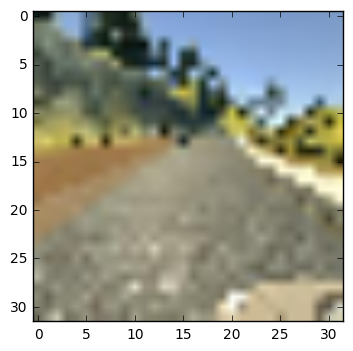

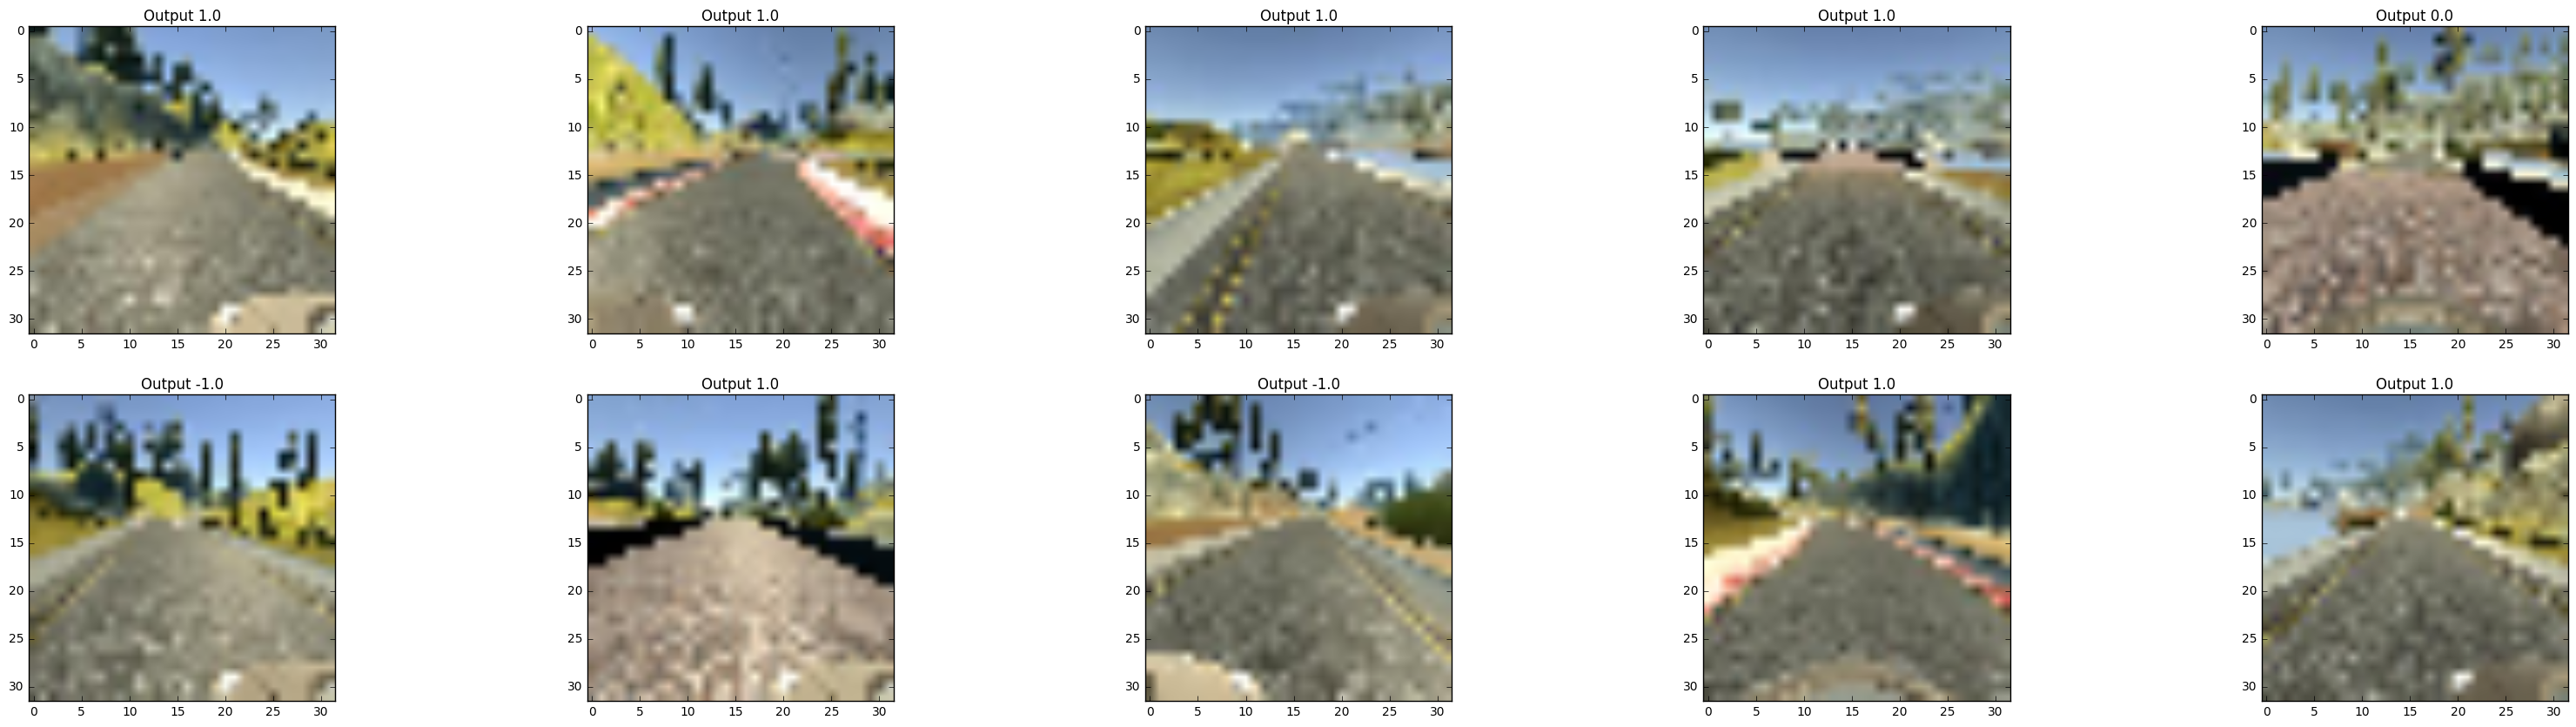

In [41]:
def process_image(image):
    return cv2.resize(image, (32,32))

def image_gen(batch_size):
    '''
    generator for a random batch with original and augmented data
    :param batch_size
    '''
    df = df_cars.sample(batch_size)
    batch_images = []
    batch_steerings = []
    batch_labels = []
    cameras = ['left' ,'center', 'right']
    correction = [0.2, 0., -0.2]
    while True:        
        for idx, row in df.iterrows():
            #img_center = np.asarray(plt.imread(path + row['center']))

            # select left,right,center camera randomly
            cam_idx = np.random.randint(3)
            camera = cameras[cam_idx]
            # read images, there are some wrong spaces in the file strings
            image = plt.imread(path + row[camera].replace(' ', ''))
            image = process_image(image)
            steering = np.float32(row['steering'] + correction[cam_idx] )
            label = np.sign(steering) 

            batch_labels.append(label)
            batch_images.append(image)
            batch_steerings.append(steering)
        yield np.array(batch_images), np.array(batch_steerings), np.array(batch_labels)


example_images, example_steerings, example_labels = next(image_gen(10))
print(type(example_images))
plt.imshow(example_images[0])
plot_images(example_images, example_labels)


In [ ]:
plot_histogram(labels, 3)

In [ ]:

print("Image shape ", img_center[0].shape)
print("Number of images", len(img_center))
plt.imshow(img_center[0])
plt.show()
plt.imshow(img_right[0])
assert(len(img_center) == len(steering_center))